In [ ]:
# Importación de librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Función para agilizar la visualización de imágenes
def show(img, title="", scale=1):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5 * scale, 5 * scale))
    plt.title(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [9]:
# Función para variar de detector
def crear_detector(tipo):
    if tipo == "SIFT":
        return cv2.SIFT_create(), cv2.NORM_L2
    elif tipo == "ORB":
        return cv2.ORB_create(nfeatures=5000), cv2.NORM_HAMMING
    elif tipo == "AKAZE":
        return cv2.AKAZE_create(), cv2.NORM_HAMMING
    else:
        raise ValueError("Tipo de detector no válido (usa 'SIFT', 'ORB' o 'AKAZE')")

In [10]:
# Carga de las imágenes
img1 = cv2.imread(r'./IMG02.jpg')
img2 = cv2.imread(r'./IMG01.jpg')
img3 = cv2.imread(r'./IMG03.jpg')

In [41]:
# Pipeline para detectar keypoints y emparejar

def procesar_imagenes(img1, img2, img3, tipo_detector="SIFT"):
    print(f"Procesando con {tipo_detector}")

    # 1. Convertir a escala de grises
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    # 2. Crear detector y matcher
    detector, norm_type = crear_detector(tipo_detector)
    bf = cv2.BFMatcher(norm_type)

    # Detectar keypoints y descriptores
    kp1, des1 = detector.detectAndCompute(img1_gray, None)
    kp2, des2 = detector.detectAndCompute(img2_gray, None)
    kp3, des3 = detector.detectAndCompute(img3_gray, None)

    # Mostrar keypoints
    img1_with_keypoints = cv2.drawKeypoints(img1_gray, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_with_keypoints = cv2.drawKeypoints(img2_gray, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img3_with_keypoints = cv2.drawKeypoints(img3_gray, kp3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    show(img1_with_keypoints, 'Keypoints en Imagen Fija')
    show(img2_with_keypoints, 'Keypoints en Imagen Móvil 1')
    show(img3_with_keypoints, 'Keypoints en Imagen Móvil 2')

    # 3. Emparejar descriptores (usando la imagen fija como referencia)
    bf = cv2.BFMatcher(cv2.NORM_L2)

    def obtener_homografia(img_fija, img_movil, kp_fija, des_fija, kp_movil, des_movil):
        matches = bf.knnMatch(des_movil, des_fija, k=2)
        buenos_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        print(f"Emparejamiento buenos: {len(buenos_matches)} con {tipo_detector}")

        if len(buenos_matches) < 4:
            raise ValueError("No hay suficientes matches para calcular homografía")

        pts_movil = np.float32([kp_movil[m.queryIdx].pt for m in buenos_matches]).reshape(-1, 1, 2)
        pts_fija = np.float32([kp_fija[m.trainIdx].pt for m in buenos_matches]).reshape(-1, 1, 2)
        H_ransac, mask_ransac = cv2.findHomography(pts_movil, pts_fija, cv2.RANSAC, 10.0)
        return H_ransac, mask_ransac, buenos_matches

    # Calcular homografías respecto a la imagen fija
    H_21, mask_21, matches_21 = obtener_homografia(img1_gray, img2_gray, kp1, des1, kp2, des2)
    H_31, mask_31, matches_31 = obtener_homografia(img1_gray, img3_gray, kp1, des1, kp3, des3)

    # Visualización de los buenos matches 1,2
    img_matches_1 = cv2.drawMatches(img2_gray, kp2,
                                img1_gray, kp1,
                                matches_21, None,
                                matchesThickness=1,
                                flags=2)

    # Visualización de los buenos matches 1,2
    img_matches_2 = cv2.drawMatches(img3_gray, kp3,
                                img1_gray, kp1,
                                matches_31, None,
                                matchesThickness=1,
                                flags=2)

    # Visualización del resultado
    show(img_matches_1, f"{tipo_detector} Feature Matching img 1 y 2", 3)
    show(img_matches_2, f"{tipo_detector} Feature Matching img 1 y 3", 3)

    # La máscara 'mask_ransac' nos dice qué puntos son 'inliers'
    matches_mask_ransac_1 = mask_21.ravel().tolist()
    # Dibuja SOLO los inliers (los matches que RANSAC consideró buenos)
    img_matches_ransac_1 = cv2.drawMatches(
        img2_gray, kp2,
        img1_gray, kp1,
        matches_21, None,
        # Se usa la máscara RANSAC para filtrar los matches
        matchesMask=matches_mask_ransac_1,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # La máscara 'mask_ransac' nos dice qué puntos son 'inliers'
    matches_mask_ransac_2 = mask_31.ravel().tolist()
    # Dibuja SOLO los inliers (los matches que RANSAC consideró buenos)
    img_matches_ransac_2 = cv2.drawMatches(
        img3_gray, kp3,
        img1_gray, kp1,
        matches_31, None,
        # Se usa la máscara RANSAC para filtrar los matches
        matchesMask=matches_mask_ransac_2,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Visualiza todos los matches después de RANSAC
    show(img_matches_ransac_1, f"Matches DESPUÉS de RANSAC (Solo Inliers) {tipo_detector} img 1 y 2", 3)
    show(img_matches_ransac_2, f"Matches DESPUÉS de RANSAC (Solo Inliers) {tipo_detector} img 1 y 3", 3)

    return H_21, H_31

# Pipeline para unir las imágenes en un solo lienzo combinado

def unir_imagenes(img1, img2, img3, H_1, H_2):    
    
    # Calcular tamaño del lienzo combinado 
    # Obtener dimensiones
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h3, w3 = img3.shape[:2]

    # Esquinas de la imagen FIJA
    corners_1 = np.float32([[0,0],[0,h1-1],[w1-1,h1-1],[w1-1,0]]).reshape(-1,1,2)
    # Esquinas de las imagenes MÓVIL
    corners_2 = np.float32([[0,0],[0,h2-1],[w2-1,h2-1],[w2-1,0]]).reshape(-1,1,2)
    corners_3 = np.float32([[0,0],[0,h3-1],[w3-1,h3-1],[w3-1,0]]).reshape(-1,1,2)

    # Usamos H para ver dónde "aterrizan" las esquinas de la imagen móvil en la fija
    corners_2_trans = cv2.perspectiveTransform(corners_2, H_1)
    corners_3_trans = cv2.perspectiveTransform(corners_3, H_2)

    # Cálculo de los límites del nuevo lienzo:
    # Juntamos todas las esquinas (las 4 de la fija y las 4 transformadas de las móviles)
    all_corners = np.concatenate((corners_1, corners_2_trans, corners_3_trans), axis=0)

    # Encontramos los valores X e Y mínimos y máximos de todas las esquinas
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    t_x, t_y = -x_min, -y_min

    # Calculamos el nuevo tamaño del lienzo
    new_w = x_max - x_min
    new_h = y_max - y_min
    print(f"Lienzo panorama: {new_w} x {new_h}")

    # Aplicar homografías y combinar imágenes

    # Crear la matriz de Traslación T para el desplazamiento
    # adicional de la imagen móvil. Esta matriz mueve todo el sistema para que quepa en el lienzo
    T = np.array([[1, 0, t_x],
                [0, 1, t_y],
                [0, 0, 1]], dtype=np.float32)

    # Combinar las transformaciones con la traslación
    H_21_comb = T.dot(H_1)
    H_31_comb = T.dot(H_2)

    # Warp de las tres imágenes
    lienzo_fijo = cv2.warpPerspective(img1, T, (new_w, new_h))
    lienzo_2 = cv2.warpPerspective(img2, H_21_comb, (new_w, new_h))
    lienzo_3 = cv2.warpPerspective(img3, H_31_comb, (new_w, new_h))

    resultado = lienzo_fijo.copy()

    mask2 = cv2.cvtColor(lienzo_2, cv2.COLOR_BGR2GRAY) 
    mask3 = cv2.cvtColor(lienzo_3, cv2.COLOR_BGR2GRAY)

    resultado[mask2 > 0] = lienzo_2[mask2 > 0] 
    resultado[mask3 > 0] = lienzo_3[mask3 > 0]

    show(np.uint8(resultado), f"Panorama", 3)

    return resultado




## Aplicación con SIFT

Procesando con SIFT


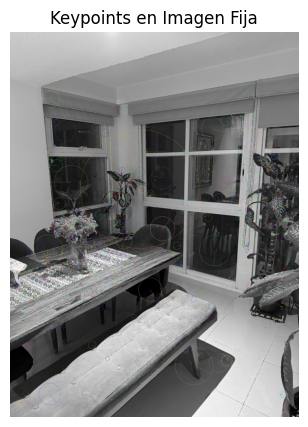

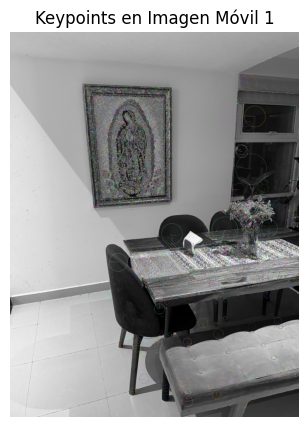

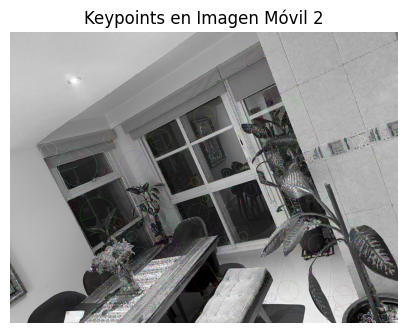

Emparejamiento buenos: 5795 con SIFT
Emparejamiento buenos: 5959 con SIFT


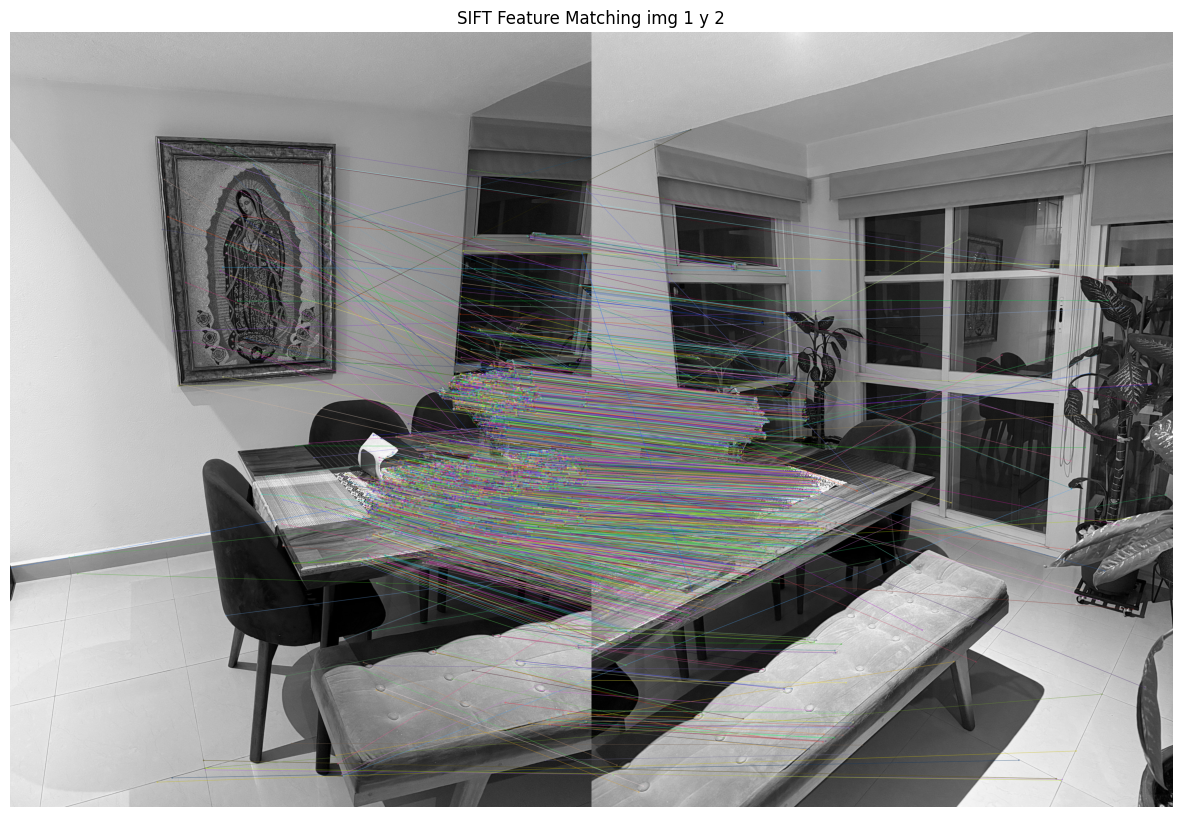

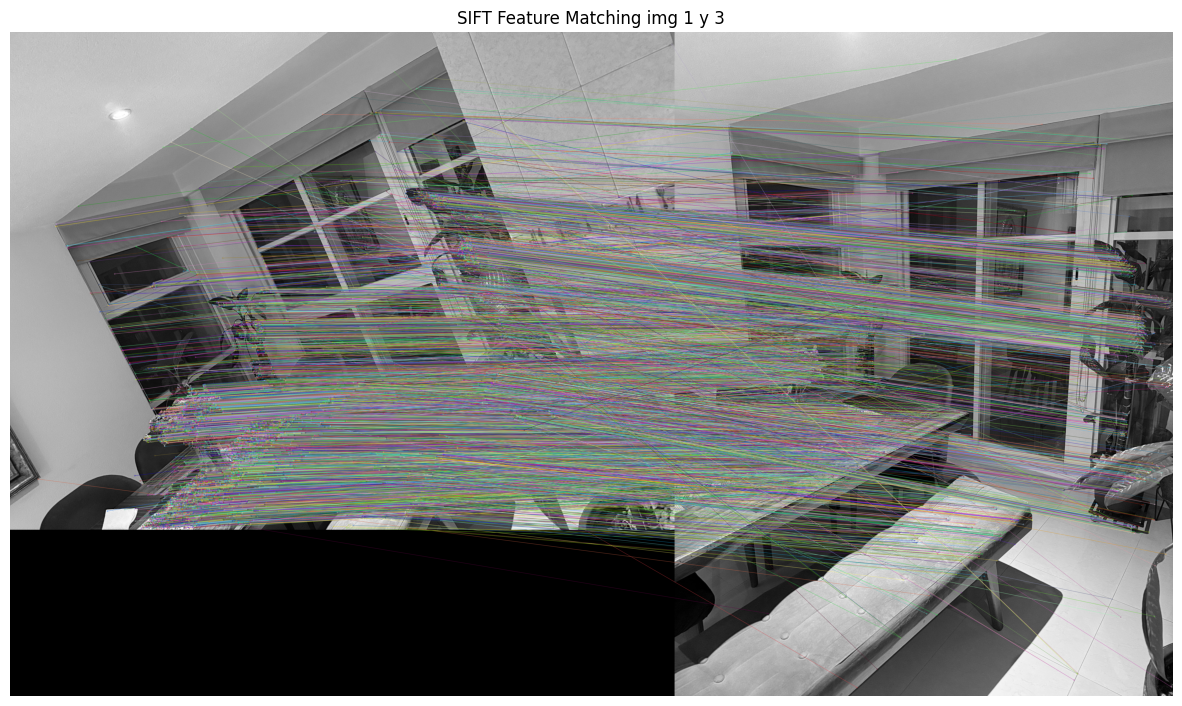

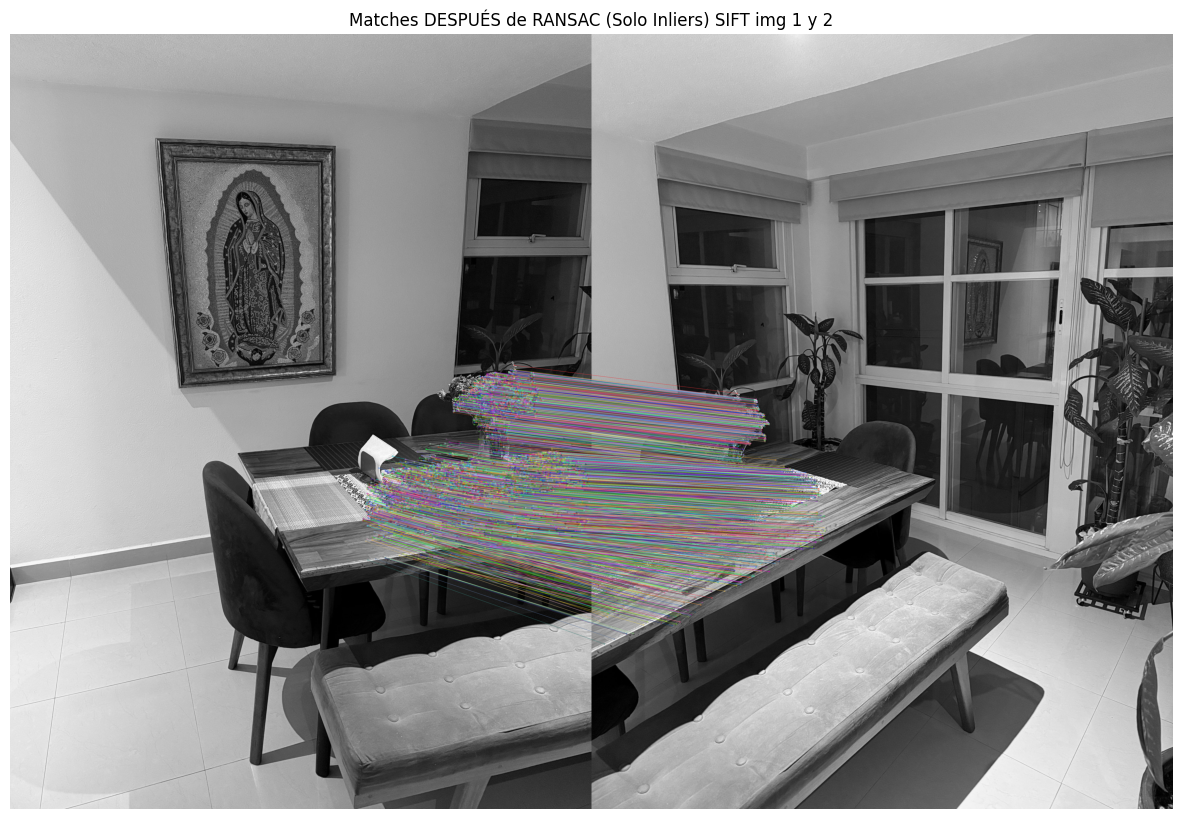

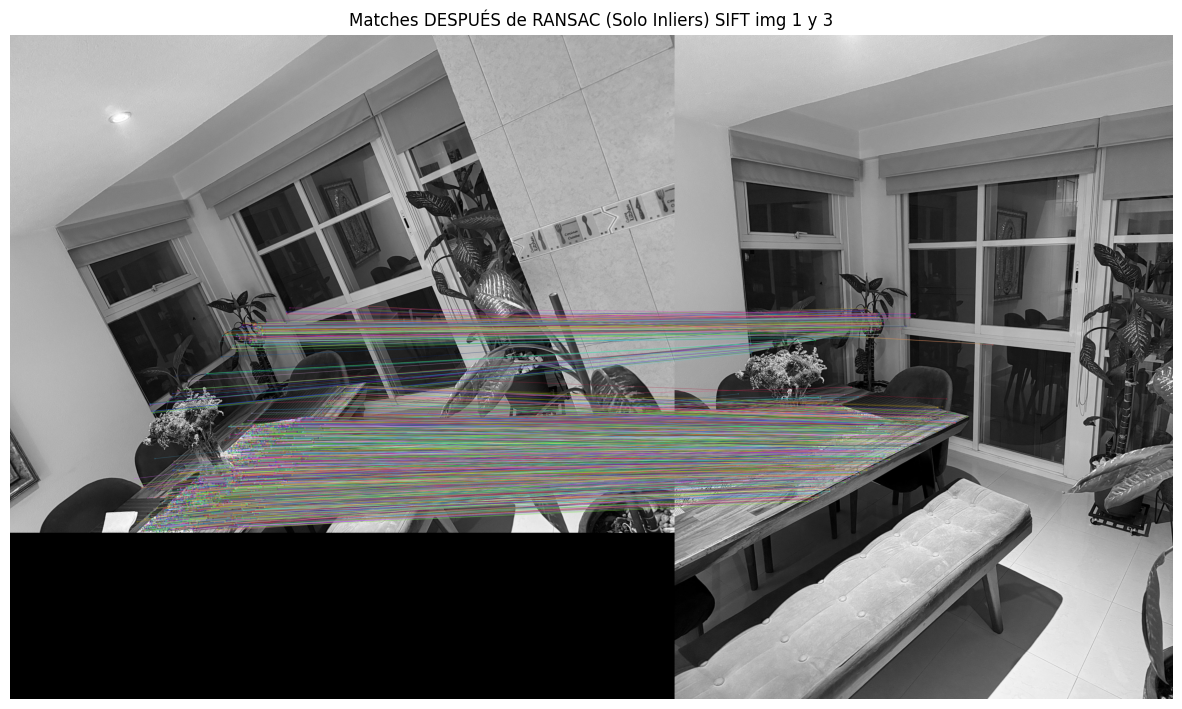

In [42]:
homografia1_SIFT, homografia2_SIFT = procesar_imagenes(img1, img2, img3, "SIFT")


Lienzo panorama: 9802 x 9623


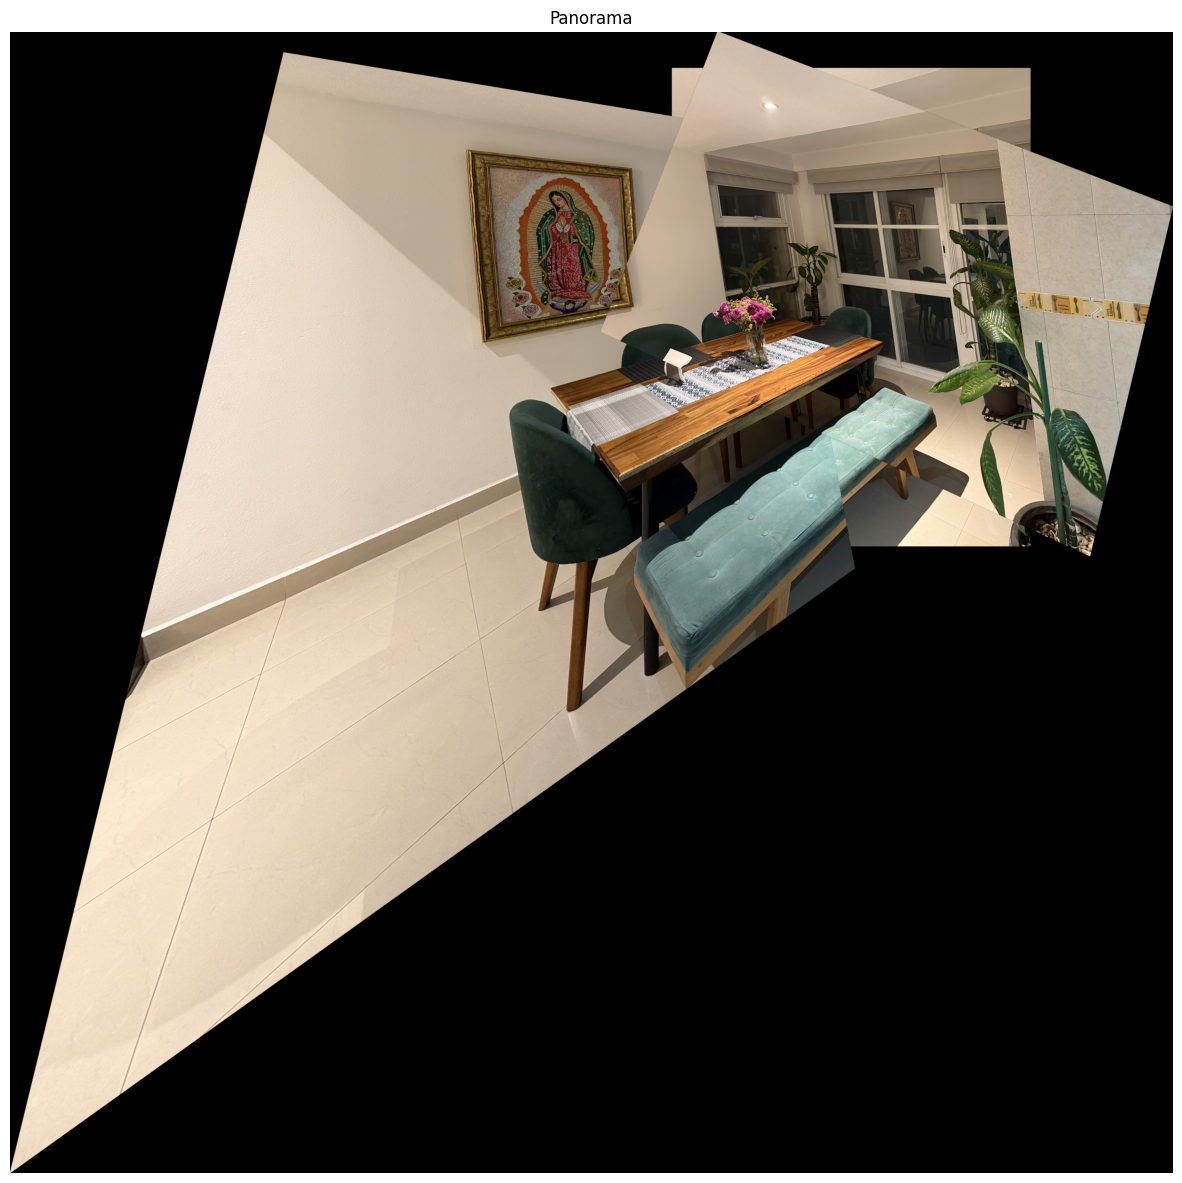

In [43]:
resultado_SIFT = unir_imagenes(img1, img2, img3, homografia1_SIFT, homografia2_SIFT)

## Aplicación con otros detectores:

In [ ]:
homografia1_ORB, homografia2_ORB = procesar_imagenes(img1, img2, img3, "ORB")
resultado_ORB = unir_imagenes(img1, img2, img3, homografia1_ORB, homografia2_ORB)

In [ ]:
homografia1_AKA, homografia2_AKA = procesar_imagenes(img1, img2, img3, "AKAZE")
resultado_AKAZE = unir_imagenes(img1, img2, img3, homografia1_AKA, homografia2_AKA)

## Script interactivo para la medición de distancias

In [44]:
import cv2
import numpy as np

# Uso: selecciona con clicks los extremos del cuadro o de la mesa
# (ya fusionadas en la imagen final)
# y define su longitud real conocida en centímetros.
# Luego se podrá medir cualquier otra distancia.

IMG = resultado_SIFT

# Variables globales
puntos_ref = []
puntos_medida = []
escala_pix_por_cm = None
mosaico_original = IMG.copy()  # fusionada final

# Redimensionar la imagen
max_width = 1080
h, w = mosaico_original.shape[:2]
if w > max_width:
    scale_factor = max_width / w
    mosaico_display = cv2.resize(mosaico_original, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
else:
    scale_factor = 1.0
    mosaico_display = mosaico_original.copy()

mosaico = mosaico_display.copy()

# Pide la longitud conocida antes de abrir la ventana
long_real = float(input("Introduce la longitud real (cm) del objeto de referencia: "))

def dibujar_linea(img, p1, p2, texto, color=(0, 255, 0)):
    cv2.line(img, p1, p2, color, 2)
    cv2.circle(img, p1, 5, (0, 0, 255), -1)
    cv2.circle(img, p2, 5, (0, 0, 255), -1)
    mid_x = int((p1[0] + p2[0]) / 2)
    mid_y = int((p1[1] + p2[1]) / 2)
    cv2.putText(img, texto, (mid_x + 10, mid_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

def medir_distancia(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def mostrar_instrucciones(img, texto):
    overlay = img.copy()
    (tw, th), _ = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(overlay, (10, 10), (30 + tw, 60), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, img, 0.4, 0, img)
    cv2.putText(img, texto, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

def actualizar_instrucciones():
    img_copy = mosaico.copy()
    if escala_pix_por_cm is None:
        mostrar_instrucciones(img_copy, "Haz clic en dos puntos de referencia para calibrar.")
    else:
        mostrar_instrucciones(img_copy, "Haz clic en dos puntos para medir distancias (Esc calibrada)")
    cv2.imshow("Mosaico final", img_copy)
    return img_copy

def click_event(event, x, y, flags, param):
    global puntos_ref, puntos_medida, escala_pix_por_cm, mosaico

    if event == cv2.EVENT_LBUTTONDOWN:
        if escala_pix_por_cm is None:
            puntos_ref.append((x, y))
            if len(puntos_ref) == 2:
                dist_px_display = medir_distancia(puntos_ref[0], puntos_ref[1])
                dist_px_original = dist_px_display / scale_factor
                escala_pix_por_cm = dist_px_original / long_real
                texto = f"Escala: {escala_pix_por_cm:.2f} px/cm"
                dibujar_linea(mosaico, puntos_ref[0], puntos_ref[1], texto, (255, 0, 0))
                mosaico = actualizar_instrucciones()
        else:
            puntos_medida.append((x, y))
            if len(puntos_medida) == 2:
                dist_px_display = medir_distancia(puntos_medida[0], puntos_medida[1])
                dist_px_original = dist_px_display / scale_factor
                dist_cm = dist_px_original / escala_pix_por_cm
                texto = f"{dist_cm:.2f} cm"
                dibujar_linea(mosaico, puntos_medida[0], puntos_medida[1], texto, (0, 255, 0))
                mosaico = actualizar_instrucciones()
                puntos_medida = []

# Mostrar imagen
mosaico = actualizar_instrucciones()
cv2.setMouseCallback("Mosaico final", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()
